In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
sns.set()

In [2]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    searched = []
    found = []
    time = 0
    rss = 0
    threads = 1
    ds_type = None
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
                threads = 1
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "Buffered_SBWT" in line:
                ds_type = "BSBWT"
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "Bifrost":
                            data[f"{ds_type}-{threads}"].append((time, rss))
                        else:
                            data[ds_type].append((time, rss))
            elif line.startswith("Saw "):
                elems = int(line.split()[1])
                searched.append(elems)
            elif line.startswith("matched"):
                elems = int(line.split()[1])
                found.append(elems)
            elif "with " in line and "31-mers" in line:
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
            elif line.startswith("threads"):
                threads = 32
    return {
        "size": sizes, 
        "searched": searched,
        "found": found,
        "data": data
    }

In [3]:
def plot_time_and_space(res, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[0] * 1000**3 / s for vv, s in zip(v, res["searched"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("Query time ns / k-mer")
    plt.legend()
    plt.title("query time")
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, res["size"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS bits / k-mer")
    plt.legend()
    plt.title("memory efficiency")
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name)
    plt.show()

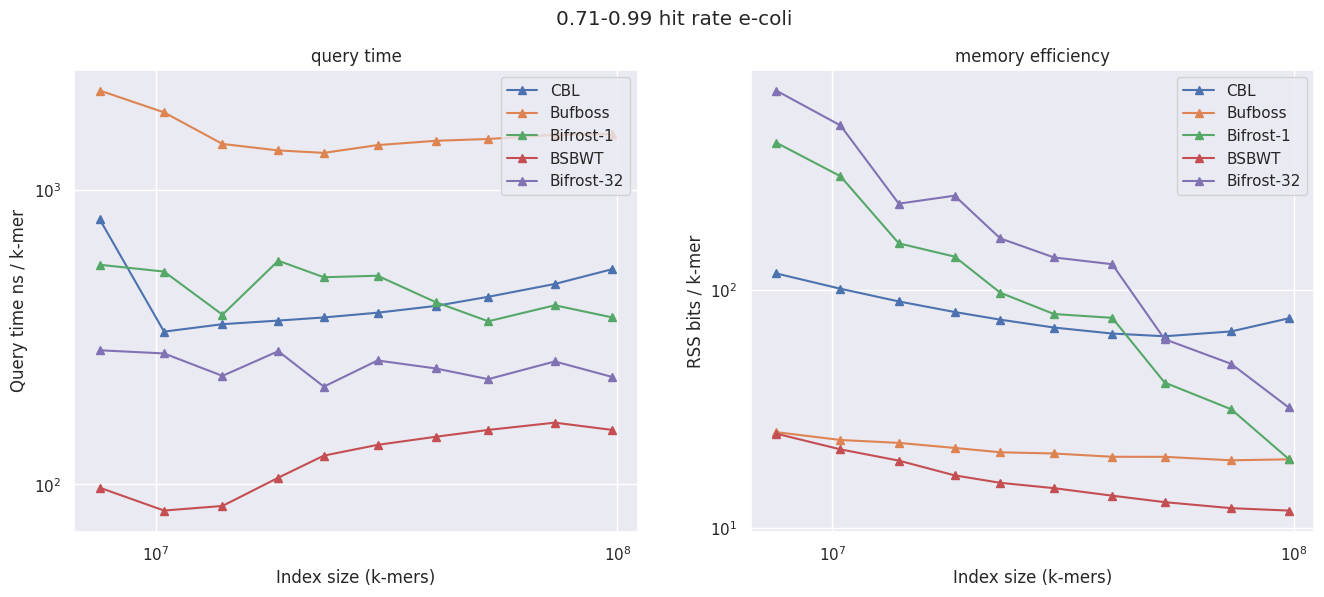

In [6]:
coli_res = read_res("../bbb_res/query_coli.txt")
h_r = [b / a for a, b in zip(coli_res["searched"], coli_res["found"])]
plot_time_and_space(coli_res, f"{h_r[0]:.2}-{h_r[-1]:.2} hit rate e-coli")

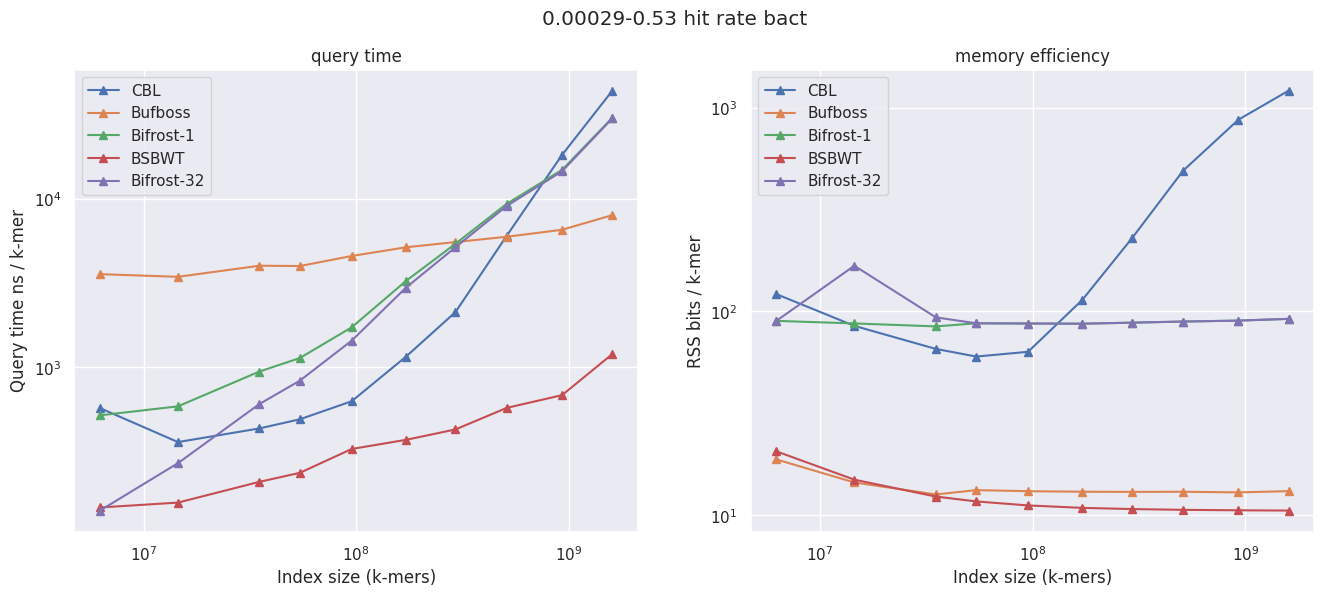

In [7]:
bact_res = read_res("../bbb_res/query_bact.txt")
h_r = [b / a for a, b in zip(bact_res["searched"], bact_res["found"])]
plot_time_and_space(bact_res, f"{h_r[0]:.2}-{h_r[-1]:.2} hit rate bact")

In [8]:
bact_res

{'size': [6242519,
  14510998,
  35071340,
  54300122,
  95192887,
  171225115,
  292696118,
  509851461,
  928233628,
  1600867786],
 'searched': [9894142,
  9894142,
  9894142,
  9894142,
  9894142,
  9894142,
  9894142,
  9894142,
  9894142,
  9894142],
 'found': [2916,
  3371629,
  3371785,
  3803896,
  3954965,
  4106678,
  4673941,
  4828725,
  5189268,
  5260094],
 'data': defaultdict(list,
             {'CBL': [(5.65, 90.49609375),
               (3.55, 146.9921875),
               (4.28, 273.8125),
               (4.85, 388.87109375),
               (6.21, 719.37890625),
               (11.43, 2326.54296875),
               (21.05, 7964.77734375),
               (59.86, 29816.6953125),
               (181.19, 96629.6015625),
               (437.09, 231547.4765625)],
              'Bufboss': [(35.37, 13.9765625),
               (34.12, 25.05859375),
               (39.71, 52.87890625),
               (39.54, 85.97265625),
               (45.37, 148.8984375),
               (51.

In [9]:
11.4 * 1000 * 1000 / 9894142

1.1521969262215965